# Image Clustering based on Image Features

Image feature extraction is the task of extracting semantically meaningful features given an image. This has many use cases, including image similarity and image retrieval. Moreover, most computer vision models can be used for image feature extraction, where one can remove the task-specific head (image classification, object detection etc) and get the features. These features are very useful on a higher level: edge detection, corner detection and so on. They may also contain information about the real world (e.g. what a cat looks like) depending on how deep the model is. Therefore, these outputs can be used to train new classifiers on a specific dataset. 

[Read more](https://huggingface.co/docs/transformers/main/en/tasks/image_feature_extraction)

In [6]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

from transformers import AutoTokenizer
from torchview import draw_graph

font_path = '../assets/Q-04LITE-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

rc_params = {
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
    'figure.figsize': (6, 4),
    'font.weight': 'bold',
    'font.family': 'sans-serif',
    'font.sans-serif': prop.get_name(),
    'axes.labelweight': 'bold',
}

plt.rcParams.update(rc_params)

In [7]:
from transformers import AutoImageProcessor, AutoModel
from accelerate.test_utils.testing import get_backend

DEVICE, _, _ = get_backend()
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
df = pd.read_csv('../data/aculei.csv', index_col=1)

In [9]:
df.head()

id  \
image_name                                                       
TF_ACULEI_22102021-12478.JPG  a8161745cc7fc2f36ce0b520b2fb14c0   
TF_ACULEI_14102021-12387.JPG  4a364a7e0345fc835a7d1213ee7f66ec   
TF_ACULEI_14102021-12408.JPG  7bb76938710e3e5a75bf7a0f192cc8a3   
TF_ACULEI_24102021-12509.JPG  070a1aa927426ae54cc7697c90e704fb   
TF_ACULEI_02092021-11775.JPG  fa4625455595159ad943c175127127e1   

                             predicted_animal       moon_phase  temperature  \
image_name                                                                    
TF_ACULEI_22102021-12478.JPG        wild boar        Full Moon         14.0   
TF_ACULEI_14102021-12387.JPG        wild boar    First Quarter          7.0   
TF_ACULEI_14102021-12408.JPG              fox    First Quarter          7.0   
TF_ACULEI_24102021-12509.JPG              fox   Waning Gibbous         11.0   
TF_ACULEI_02092021-11775.JPG              fox  Waning Crescent         14.0   

                                             date    cam  \
image_name                                                 
TF_ACULEI_22102021-12478.JPG  2021-10-22 02:45:10  Cam_1   
TF_ACULEI_14102021-12387.JPG  2021-10-14 02:53:48  Cam_1   
TF_ACULEI_14102021-12408.JPG  2021-10-14 03:16:51  Cam_1   
TF_ACULEI_24102021-12509.JPG  2021-10-24 06:22:12  Cam_1   
TF_ACULEI_02092021-11775.JPG  2021-09-02 03:08:36  Cam_1   

                                                                top_predictions  
image_name                                                                       
TF_ACULEI_22102021-12478.JPG  [{'score': 0.9813390374183655, 'label': 'wild ...  
TF_ACULEI_14102021-12387.JPG  [{'score': 0.8655636310577393, 'label': 'wild ...  
TF_ACULEI_14102021-12408.JPG  [{'score': 0.6146367788314819, 'label': 'fox'}...  
TF_ACULEI_24102021-12509.JPG  [{'score': 0.480511873960495, 'label': 'fox'},...  
TF_ACULEI_02092021-11775.JPG  [{'score': 0.5324126482009888, 'label': 'fox'}...

In [10]:
def infer(image):
  inputs = processor(image, return_tensors="pt").to(DEVICE)
  outputs = model(**inputs)
  return outputs.pooler_output

In [11]:
image_folder = "/Volumes/ACULEI_A/ACULEI/ARCHIVIO"
image_embeddings = []
for root, _, files in os.walk(image_folder):
    for file in tqdm.tqdm(files):
        if file.startswith('.') or not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(root, file)
        try:
            image = Image.open(image_path).convert('RGB')
            embedding = infer(image)
            image_embeddings.append(embedding.cpu().detach().numpy())
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 18/18 [00:03<00:00,  5.00it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:04<00:00, 10.31it/s]
0it [00:00, ?it/s]
100%|██████████| 119/119 [00:24<00:00,  4.80it/s]
0it [00:00, ?it/s]
100%|██████████| 78/78 [00:08<00:00,  9.36it/s]
0it [00:00, ?it/s]
100%|██████████| 1042/1042 [03:40<00:00,  4.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 543/543 [00:38<00:00, 14.25it/s]
0it [00:00, ?it/s]
100%|██████████| 34/34 [00:02<00:00, 12.82it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 17.01it/s]
0it [00:00, ?it/s]
100%|██████████| 15/15 [00:00<00:00, 15.23it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 28.33it/s]
0it [00:00, ?it/s]
100%|██████████| 1645/1645 [02:41<00:00, 10.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 135/135 [00:14<00:00,  9.60it/s]
0it [00:00, ?it/s]
100%|██████████| 30/30 [00:03<00:00,  9.18it/s]
0it [00:00, ?it/s]
100%|██████████| 4/4 [00

In [ ]:
# dirs = [path for path in os.listdir("../images/archive") if os.path.isdir(os.path.join("../images/archive", path))]
# image_embeddings = []
# image_paths = []

# for dir in dirs:
#     img_paths = [os.path.join("../images/archive", dir, path) for path in os.listdir(os.path.join("../images/archive", dir)) if path.endswith(".jpg")]
#     image_paths.extend(img_paths)
#     imgs = [Image.open(path) for path in img_paths if path.endswith(".jpg")]

#     for image in imgs:
#         image_embedding = infer(image)
#         image_embeddings.append(image_embedding.cpu().detach().numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../images/archive'

In [12]:
embeddings = np.concatenate([e for e in image_embeddings], axis=0)

What an image looks like under the hood

In [13]:
embeddings[0]

array([ 0.06907339, -0.22773297, -0.16278824, -0.0619711 ,  0.50832695,
       -0.06851751, -0.10288765,  0.01337968,  0.09897714,  0.01345177,
       -0.36773056,  0.3568855 , -0.18412316, -0.012933  ,  0.1086629 ,
       -0.552325  ,  0.23259063, -0.67990994,  0.15881203, -0.31035417,
        0.5061528 ,  0.34421015,  0.5727872 , -0.20334825, -0.70376563,
       -0.33929822, -0.6283927 ,  0.49790955, -0.52395487,  0.08147386,
       -0.08158336,  0.6395778 , -0.04360165, -0.17991194,  0.23206058,
        0.2525667 ,  0.5369813 , -0.37642655,  0.4819667 , -0.37583888,
        0.7804105 ,  0.42824623, -0.69139206, -0.05177082,  0.40523887,
        0.08913254, -0.6208156 , -0.54947394,  0.07439326,  0.49845845,
       -0.11574566,  0.8584931 ,  0.03410328, -0.28411603, -0.40683416,
       -0.4607128 , -0.47581157, -0.6680821 ,  0.41295928,  0.705569  ,
        0.73341876, -0.19417013,  0.51725584,  0.38898453,  0.05647941,
       -0.19845657, -0.08373246, -0.24776927, -0.72170234, -0.41

Let's reduce dimensions using Principal Component Analysis, then scale embeddings and cluster them

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

scaler = StandardScaler()
scaler.fit(tsne_embeddings)
scaled_embeddings = scaler.transform(tsne_embeddings)

We have to find out which k is the best one so we proceed with Elbow Method, testing for multiple k values

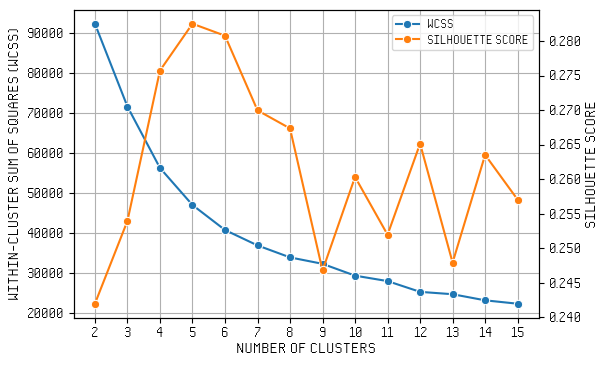

In [15]:
ks = range(2, 16)
silhouette_scores = []
wcss = []   

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    labels = kmeans.labels_
    # print(f"Silhouette score for k={k}: {silhouette_score(embeddings, labels)}")
    # print(f"WCSS for k={k}: {kmeans.inertia_}")
    silhouette_scores.append(silhouette_score(scaled_embeddings, labels))
    wcss.append(kmeans.inertia_)

fig, ax1 = plt.subplots()

sns.lineplot(x=ks, y=wcss, ax=ax1, marker="o", color=sns.color_palette("tab10")[0] , label="WCSS", errorbar='ci')
ax1.set_ylabel("Within-Cluster Sum of Squares (WCSS)".upper())

ax2 = ax1.twinx()
sns.lineplot(x=ks, y=silhouette_scores, ax=ax2, marker="o", color=sns.color_palette("tab10")[1], label="Silhouette Score", errorbar='ci')
ax2.set_ylabel("Silhouette Score".upper())

ax1.set_xlabel("Number of Clusters".upper())
# ax1.set_title("WCSS and Silhouette Score vs Number of Clusters".upper())

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best", fontsize=8)
ax2.legend_.remove()

ax1.set_xticks(ks)

for text in ax1.legend_.get_texts():
    text.set_text(text.get_text().upper())

ax1.grid(True)
plt.show()

fig.savefig("../assets/elbow-method.svg", format='svg', bbox_inches='tight')

Looks like something between 3 and 8 should be good

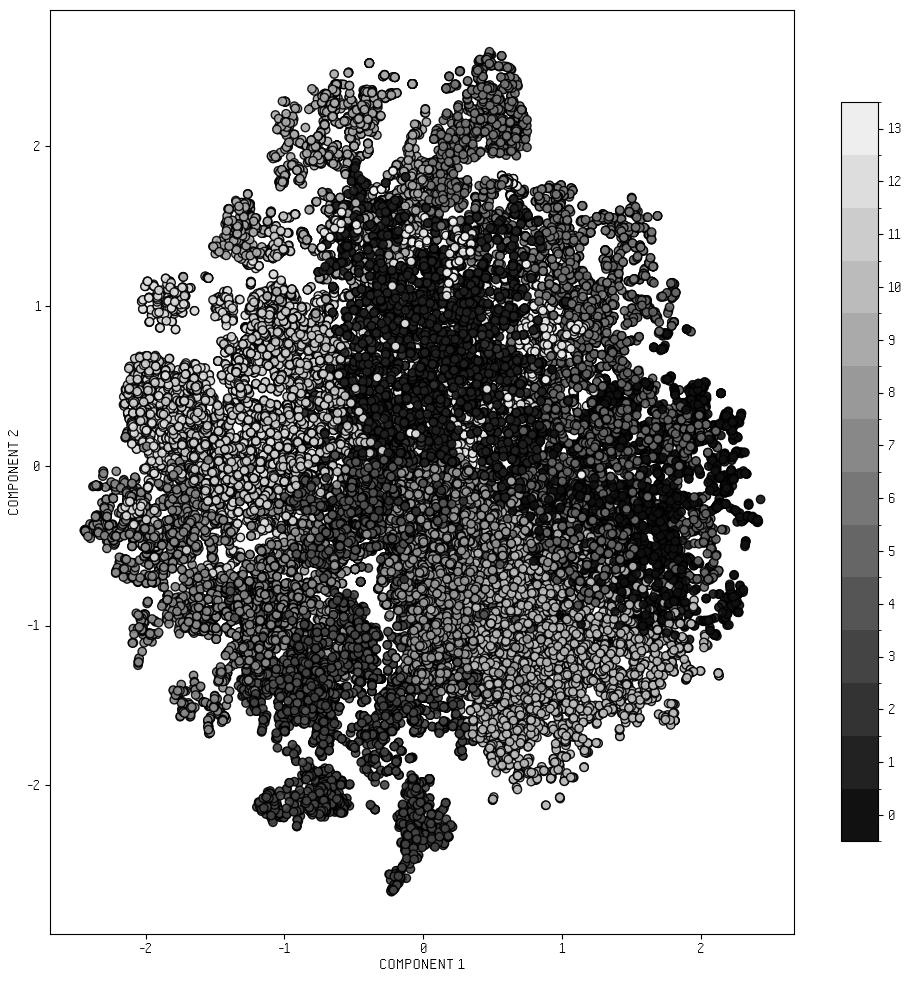

In [31]:
n_clusters = 14
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)

palette = sns.color_palette("gray", n_colors=n_clusters)
cmap = mpl.colors.ListedColormap(palette)
norm = mpl.colors.BoundaryNorm(np.arange(-0.5, n_clusters + 0.5), n_clusters)

fig, ax = plt.subplots(figsize=(12, 12))

scatter = ax.scatter(
    scaled_embeddings[:, 0],
    scaled_embeddings[:, 1],
    c=clusters,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    alpha=0.9
)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=range(n_clusters), shrink=0.8)

# ax.set_title("Image Embeddings Clusters with TSNE Projection".upper())
ax.set_xlabel("Component 1".upper())
ax.set_ylabel("Component 2".upper())
ax.grid(False)
plt.show()

fig.savefig(f"../assets/clustered_embeddings_{n_clusters}.svg", format='svg', bbox_inches='tight')

In [32]:
image_paths = []
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.startswith('.') or not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(root, file)
        image_paths.append(image_path)

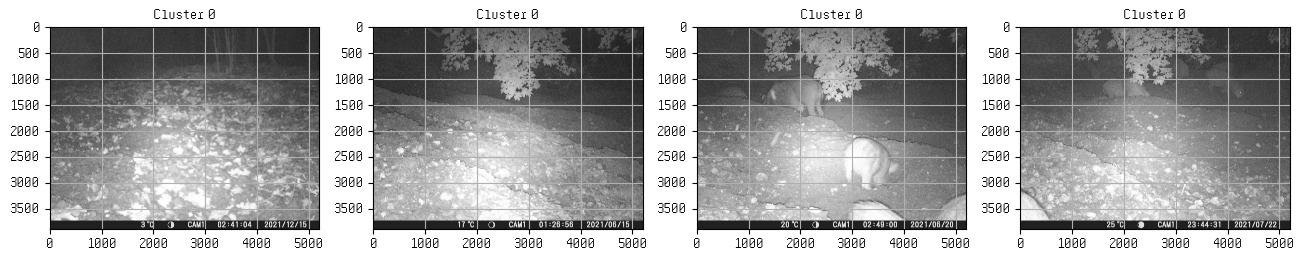

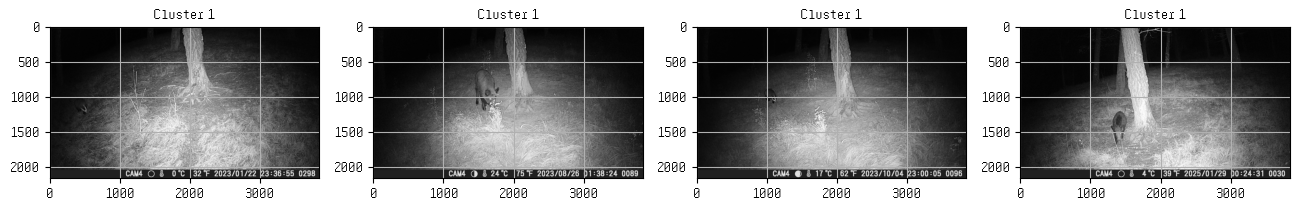

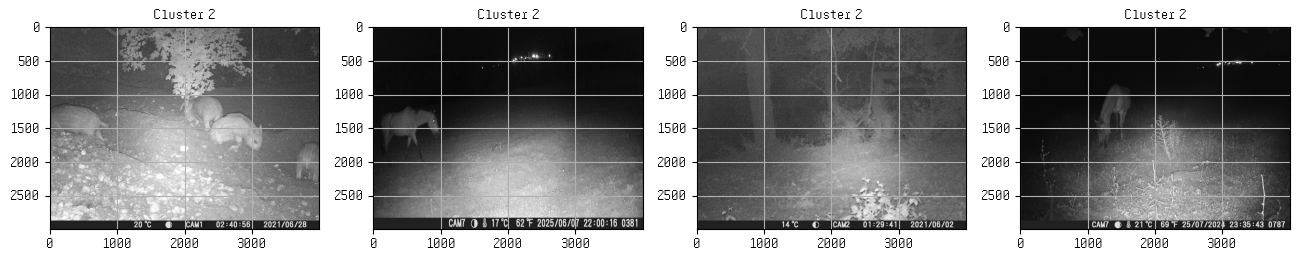

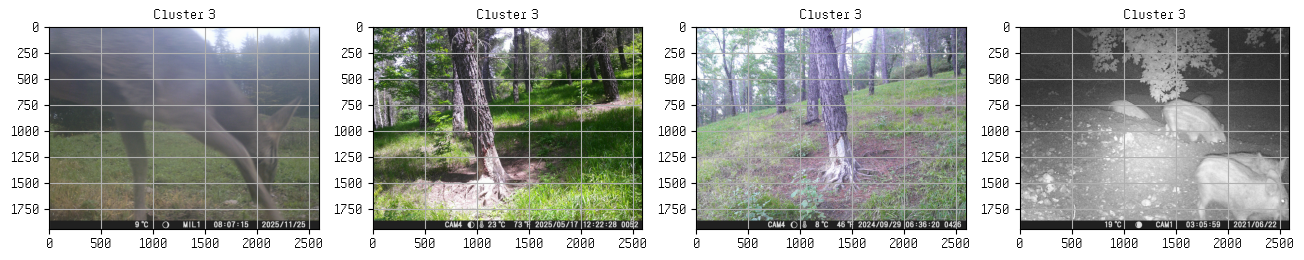

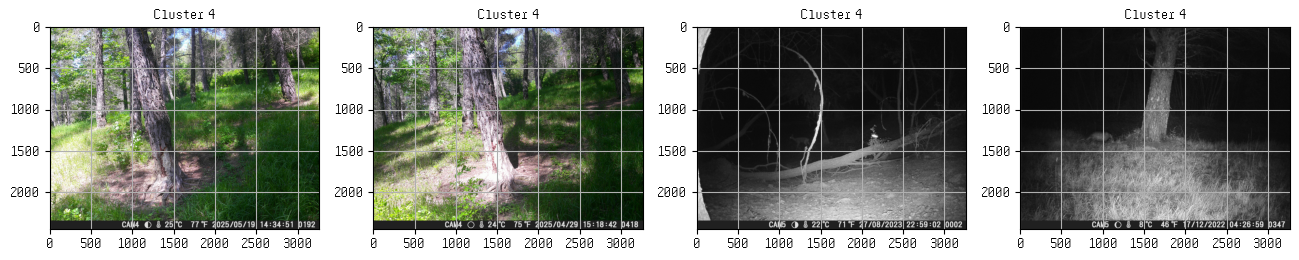

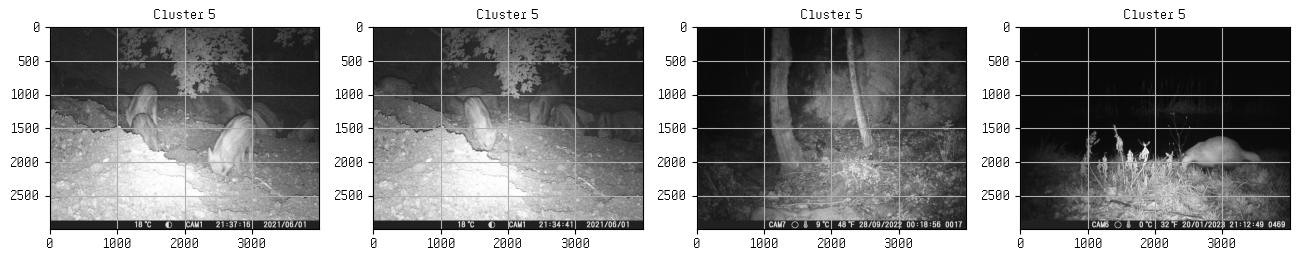

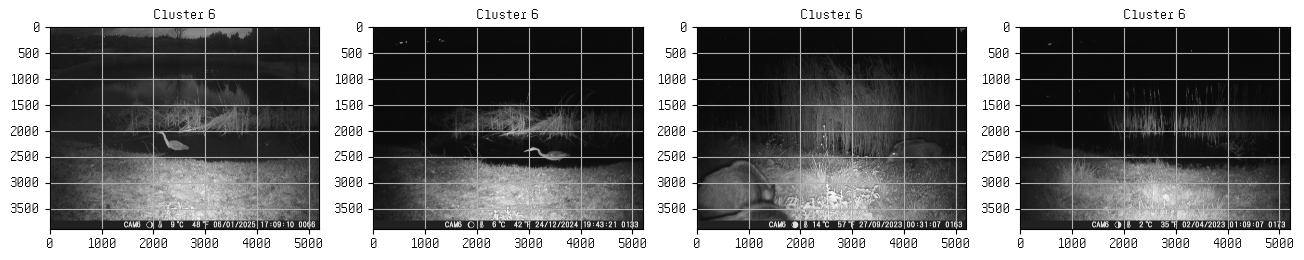

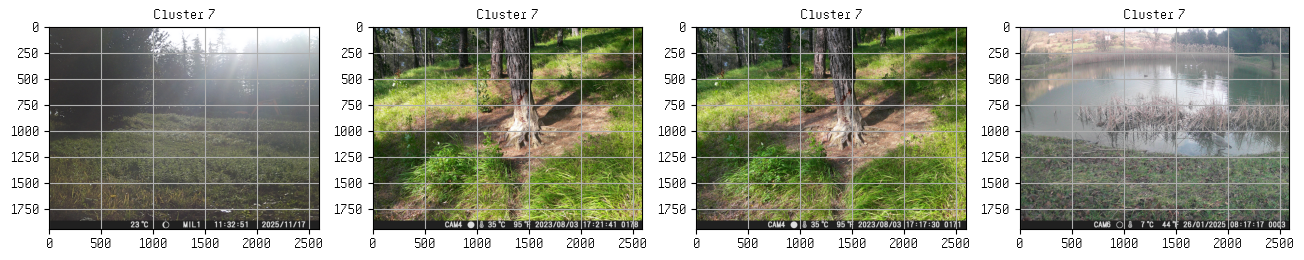

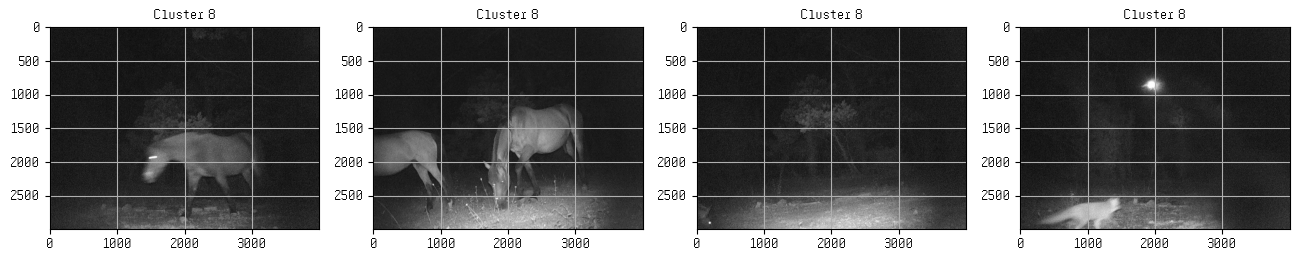

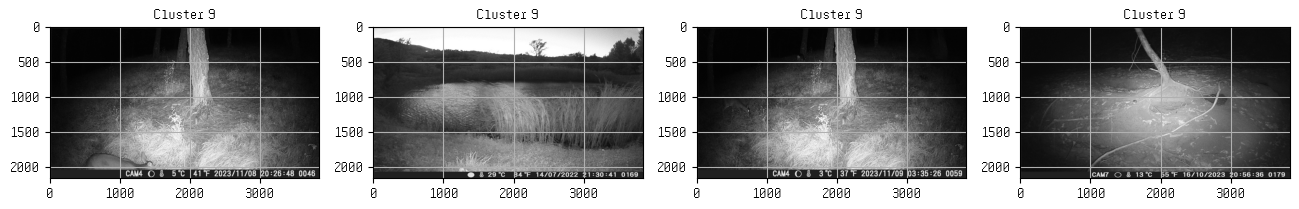

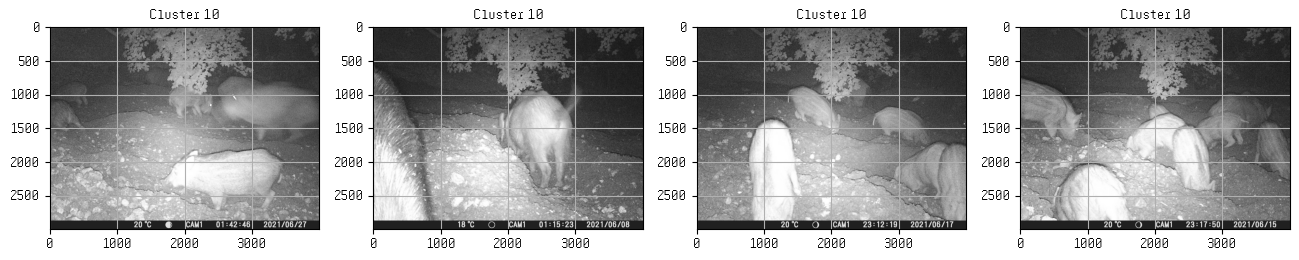

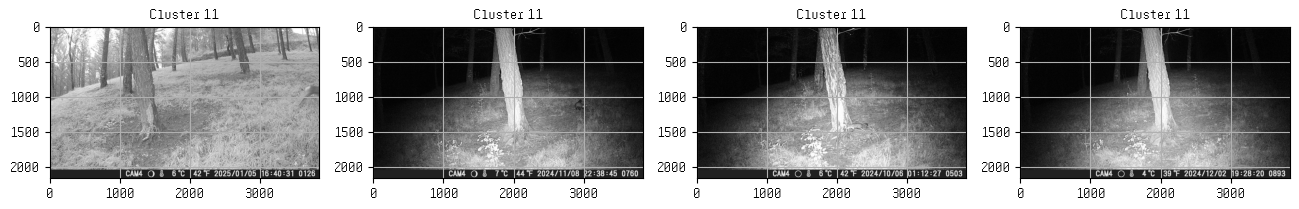

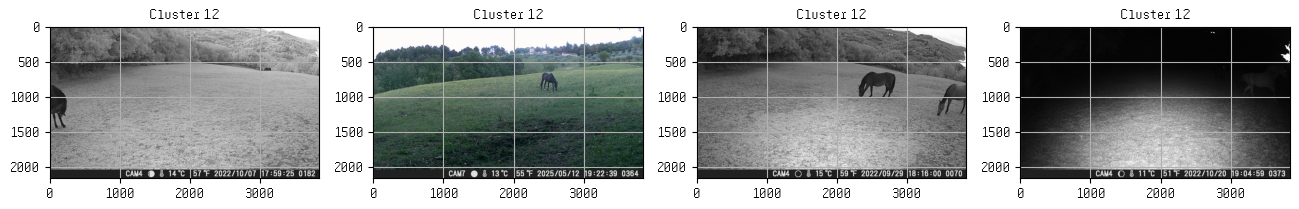

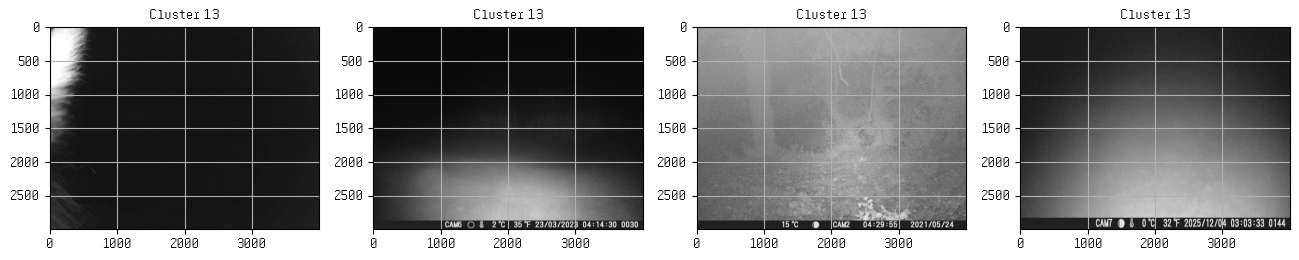

In [33]:
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]

    if len(cluster_indices) < 2:
        continue

    np.random.shuffle(cluster_indices)

    cluster_images = [Image.open(image_paths[j]) for j in cluster_indices[:4]]

    size = cluster_images[0].size

    f, ax = plt.subplots(1, len(cluster_images), figsize=(16, 4))
    for j, img in enumerate(cluster_images):
        img = img.resize((size[0], size[1]))
        ax[j].imshow(img)
        ax[j].set_title(f"Cluster {i}")
        ax[j].grid()
    plt.show()